# **AntiMicrobial Resistance Prediction from SNPs**

This notebook contains the proposed end-to-end Custom 1D CNN - XGBoost Ensemble implementations of **AMR Prediction from SNPs** project. Feel free to use/customise the code.

# **CIP**

##**Setup & Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn and Model Imports ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score,
    f1_score, roc_curve, auc, cohen_kappa_score, matthews_corrcoef,
    precision_recall_curve
)
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb

print("Setup Complete for Simple Prediction Averaging Ensemble.")

# --- Configuration ---
SNP_MATRIX_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_multi_data.csv"
PHENOTYPES_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_pheno.csv"
TARGET_ANTIBIOTIC = "CIP"

# Saved Model Paths
CNN_MODEL_PATH = "/content/drive/MyDrive/AMR/Trained Weights/best_cnn1d_model_CIP.keras"
XGB_MODEL_PATH = "/content/drive/MyDrive/AMR/Trained Weights/best_xgboost_model_CIP.json"

# Data Splitting Ratio
TEST_SPLIT = 0.2

# Seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Setup Complete for Simple Prediction Averaging Ensemble.


# **Initial Preprocessing**

In [ ]:
print("\n--- Loading Data and Performing Identical Split ---")
snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
pheno_df = pd.read_csv(PHENOTYPES_FILE)
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)

labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
X = merged_df.drop(columns=[TARGET_ANTIBIOTIC]).values.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Loaded {len(y_train)} training samples and {len(y_test)} test samples.")


--- Loading Data and Performing Identical Split ---
Loaded 647 training samples and 162 test samples.


# **Loading Model & Predictions**

In [ ]:
print("\n--- Loading Pre-Trained Models and Generating Predictions ---")

# --- Loading Models ---
try:
    cnn_model = keras.models.load_model(CNN_MODEL_PATH)
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(XGB_MODEL_PATH)
    print("Base models loaded successfully.")
except Exception as e:
    print(f"Error loading models: {e}")
    exit()

# We need test set predictions for the final evaluation
print("Generating predictions for the test set (for final evaluation)...")
test_preds_cnn = cnn_model.predict(X_test, verbose=0).ravel()
test_preds_xgb = xgb_model.predict_proba(X_test)[:, 1]


--- Loading Pre-Trained Models and Generating Predictions ---
Base models loaded successfully.
Generating predictions for the training set (for threshold tuning)...
Generating predictions for the test set (for final evaluation)...


# **Model Evaluation**


--- Evaluating Simple Ensemble Model on the Test Set ---

--- FINAL ENSEMBLE PERFORMANCE (Threshold = 0.3811) ---

Overall Performance Metrics (Test Set with Tuned Threshold):
Accuracy: 0.9630
AUC Score: 0.9878
Cohen's Kappa: 0.9248
Matthews Correlation Coefficient (MCC): 0.9260

Classification Report (Tuned Threshold):
                 precision    recall  f1-score   support

Susceptible (0)     0.9462    0.9888    0.9670        89
  Resistant (1)     0.9855    0.9315    0.9577        73

       accuracy                         0.9630       162
      macro avg     0.9659    0.9601    0.9624       162
   weighted avg     0.9639    0.9630    0.9628       162


Confusion Matrix (Tuned Threshold):


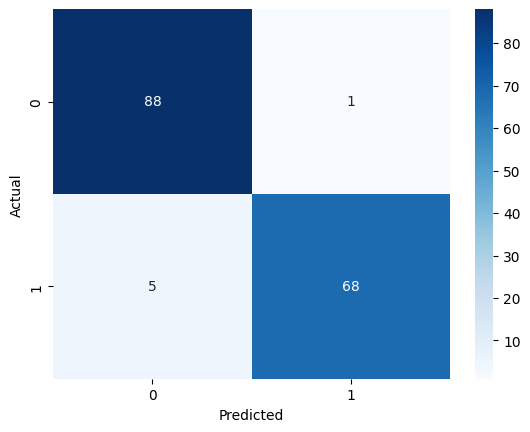

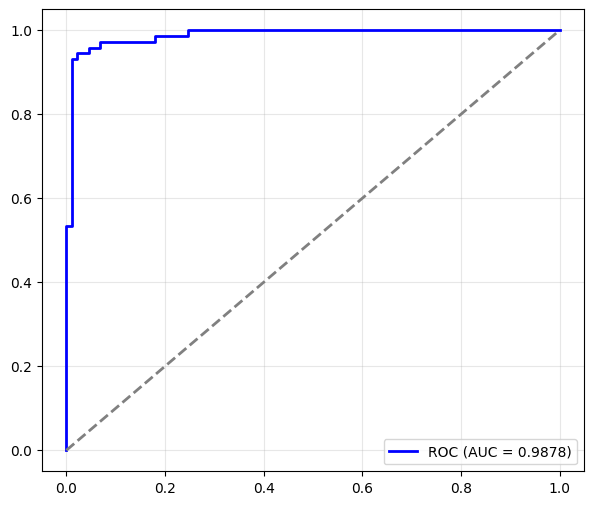

In [ ]:
print("\n--- Evaluating Simple Ensemble Model on the Test Set ---")

print("\n--- Combining Predictions and Tuning the Threshold ---")

cnn_weight = 0.5
xgb_weight = 0.5

# Combining predictions for the test set
y_pred_probs_ensemble = (cnn_weight * test_preds_cnn) + (xgb_weight * test_preds_xgb)

# Applying the OPTIMAL THRESHOLD to the combined test probabilities
y_pred_ensemble_tuned = (y_pred_probs_ensemble >= 0.55).astype(int)

# --- Calculating and Displaying All Metrics ---
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble_tuned)
auc_ensemble = roc_auc_score(y_test, y_pred_probs_ensemble)
kappa_ensemble = cohen_kappa_score(y_test, y_pred_ensemble_tuned)
mcc_ensemble = matthews_corrcoef(y_test, y_pred_ensemble_tuned)

print(f"\nOverall Performance Metrics (Test Set with Tuned Threshold):")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"AUC Score: {auc_ensemble:.4f}")
print(f"Cohen's Kappa: {kappa_ensemble:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_ensemble:.4f}")

print("\nClassification Report (Tuned Threshold):")
print(classification_report(y_test, y_pred_ensemble_tuned, target_names=["Susceptible (0)", "Resistant (1)"], digits=4))

print("\nConfusion Matrix (Tuned Threshold):")
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble_tuned)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues')
#plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (Simple Ensemble)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- ROC Curve ---
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_pred_probs_ensemble)
plt.figure(figsize=(7, 6))
plt.plot(fpr_ens, tpr_ens, color='blue', lw=2, label=f'ROC (AUC = {auc_ensemble:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
#plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (Simple Ensemble)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **CTX**

#**Setup & Imports**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-learn and Model Imports ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, roc_auc_score,
    f1_score, roc_curve, auc, cohen_kappa_score, matthews_corrcoef,
    precision_recall_curve
)
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb

print("Setup Complete for Simple Prediction Averaging Ensemble.")

# --- Configuration ---
SNP_MATRIX_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_multi_data.csv"
PHENOTYPES_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_pheno.csv"
TARGET_ANTIBIOTIC = "CTX"

# Saved Model Paths
CNN_MODEL_PATH = "/content/drive/MyDrive/AMR/Trained Weights/best_cnn1d_model_CTX.keras"
XGB_MODEL_PATH = "/content/drive/MyDrive/AMR/Trained Weights/best_xgboost_model_CTX.json"

# Data Splitting Ratio
TEST_SPLIT = 0.2

# Seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Setup Complete for Simple Prediction Averaging Ensemble.


# **Initial Preprocessing**

In [ ]:
print("\n--- Loading Data and Performing Identical Split ---")
snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
pheno_df = pd.read_csv(PHENOTYPES_FILE)
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)

labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
X = merged_df.drop(columns=[TARGET_ANTIBIOTIC]).values.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Loaded {len(y_train)} training samples and {len(y_test)} test samples.")


--- Loading Data and Performing Identical Split ---
Loaded 647 training samples and 162 test samples.


# **Loading Model & Predictions**

In [ ]:
print("\n--- Loading Pre-Trained Models and Generating Predictions ---")

# --- Loading Models ---
try:
    cnn_model = keras.models.load_model(CNN_MODEL_PATH)
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(XGB_MODEL_PATH)
    print("Base models loaded successfully.")
except Exception as e:
    print(f"Error loading models: {e}")
    exit()

# We need test set predictions for the final evaluation
print("Generating predictions for the test set (for final evaluation)...")
test_preds_cnn = cnn_model.predict(X_test, verbose=0).ravel()
test_preds_xgb = xgb_model.predict_proba(X_test)[:, 1]


--- Loading Pre-Trained Models and Generating Predictions ---
Base models loaded successfully.
Generating predictions for the test set (for final evaluation)...


# **Model Evaluation**


--- Evaluating Simple Ensemble Model on the Test Set ---

--- Combining Predictions and Tuning the Threshold ---

Overall Performance Metrics (Test Set with Tuned Threshold):
Accuracy: 0.8086
AUC Score: 0.8753
Cohen's Kappa: 0.6183
Matthews Correlation Coefficient (MCC): 0.6241

Classification Report (Tuned Threshold):
                 precision    recall  f1-score   support

Susceptible (0)     0.8734    0.7667    0.8166        90
  Resistant (1)     0.7470    0.8611    0.8000        72

       accuracy                         0.8086       162
      macro avg     0.8102    0.8139    0.8083       162
   weighted avg     0.8172    0.8086    0.8092       162


Confusion Matrix (Tuned Threshold):


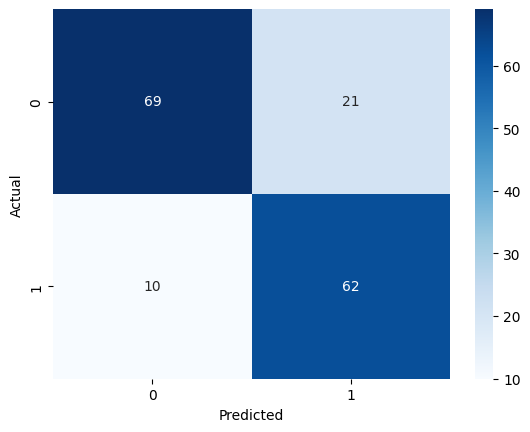

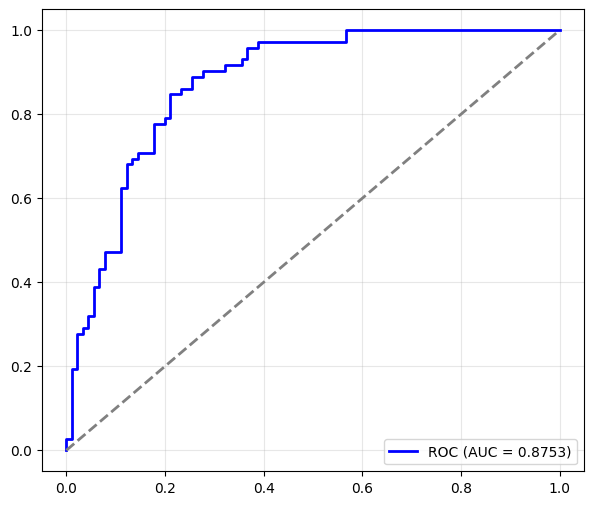

In [ ]:
print("\n--- Evaluating Simple Ensemble Model on the Test Set ---")

print("\n--- Combining Predictions and Tuning the Threshold ---")

cnn_weight = 0.5
xgb_weight = 0.5

# Combining predictions for the test set
y_pred_probs_ensemble = (cnn_weight * test_preds_cnn) + (xgb_weight * test_preds_xgb)

# Applying the OPTIMAL THRESHOLD to the combined test probabilities
y_pred_ensemble_tuned = (y_pred_probs_ensemble >= 0.48).astype(int)

# --- Calculating and Displaying All Metrics ---
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble_tuned)
auc_ensemble = roc_auc_score(y_test, y_pred_probs_ensemble)
kappa_ensemble = cohen_kappa_score(y_test, y_pred_ensemble_tuned)
mcc_ensemble = matthews_corrcoef(y_test, y_pred_ensemble_tuned)

print(f"\nOverall Performance Metrics (Test Set with Tuned Threshold):")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"AUC Score: {auc_ensemble:.4f}")
print(f"Cohen's Kappa: {kappa_ensemble:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_ensemble:.4f}")

print("\nClassification Report (Tuned Threshold):")
print(classification_report(y_test, y_pred_ensemble_tuned, target_names=["Susceptible (0)", "Resistant (1)"], digits=4))

print("\nConfusion Matrix (Tuned Threshold):")
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble_tuned)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues')
#plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (Simple Ensemble)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- ROC Curve ---
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_pred_probs_ensemble)
plt.figure(figsize=(7, 6))
plt.plot(fpr_ens, tpr_ens, color='blue', lw=2, label=f'ROC (AUC = {auc_ensemble:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
#plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (Simple Ensemble)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **CTZ**

#**Setup & Imports**

In [ ]:
print("Setup Complete for Simple Prediction Averaging Ensemble.")

# --- Configuration ---
SNP_MATRIX_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_multi_data.csv"
PHENOTYPES_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_pheno.csv"
TARGET_ANTIBIOTIC = "CTZ"

# Saved Model Paths
CNN_MODEL_PATH = "/content/drive/MyDrive/AMR/Trained Weights/best_cnn1d_model_CTZ.keras"
XGB_MODEL_PATH = "/content/drive/MyDrive/AMR/Trained Weights/best_xgboost_model_CTZ.json"

# Data Splitting Ratio
TEST_SPLIT = 0.2

# Seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Setup Complete for Simple Prediction Averaging Ensemble.


# **Initial Preprocessing**

In [ ]:
print("\n--- Loading Data and Performing Identical Split ---")
snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
pheno_df = pd.read_csv(PHENOTYPES_FILE)
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)

labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
X = merged_df.drop(columns=[TARGET_ANTIBIOTIC]).values.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Loaded {len(y_train)} training samples and {len(y_test)} test samples.")


--- Loading Data and Performing Identical Split ---
Loaded 647 training samples and 162 test samples.


# **Loading Model & Predictions**

In [ ]:
print("\n--- Loading Pre-Trained Models and Generating Predictions ---")

# --- Loading Models ---
try:
    cnn_model = keras.models.load_model(CNN_MODEL_PATH)
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(XGB_MODEL_PATH)
    print("Base models loaded successfully.")
except Exception as e:
    print(f"Error loading models: {e}")
    exit()

# We need test set predictions for the final evaluation
print("Generating predictions for the test set (for final evaluation)...")
test_preds_cnn = cnn_model.predict(X_test, verbose=0).ravel()
test_preds_xgb = xgb_model.predict_proba(X_test)[:, 1]


--- Loading Pre-Trained Models and Generating Predictions ---
Base models loaded successfully.
Generating predictions for the test set (for final evaluation)...


# **Model Evaluation**


--- Evaluating Simple Ensemble Model on the Test Set ---

--- Combining Predictions and Tuning the Threshold ---

Overall Performance Metrics (Test Set with Tuned Threshold):
Accuracy: 0.8086
AUC Score: 0.8253
Cohen's Kappa: 0.5714
Matthews Correlation Coefficient (MCC): 0.5715

Classification Report (Tuned Threshold):
                 precision    recall  f1-score   support

Susceptible (0)     0.8519    0.8598    0.8558       107
  Resistant (1)     0.7222    0.7091    0.7156        55

       accuracy                         0.8086       162
      macro avg     0.7870    0.7845    0.7857       162
   weighted avg     0.8078    0.8086    0.8082       162


Confusion Matrix (Tuned Threshold):


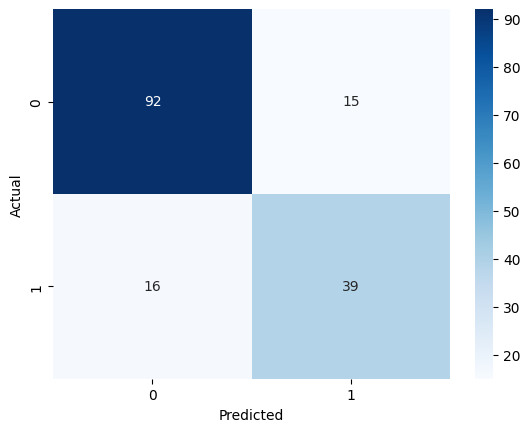

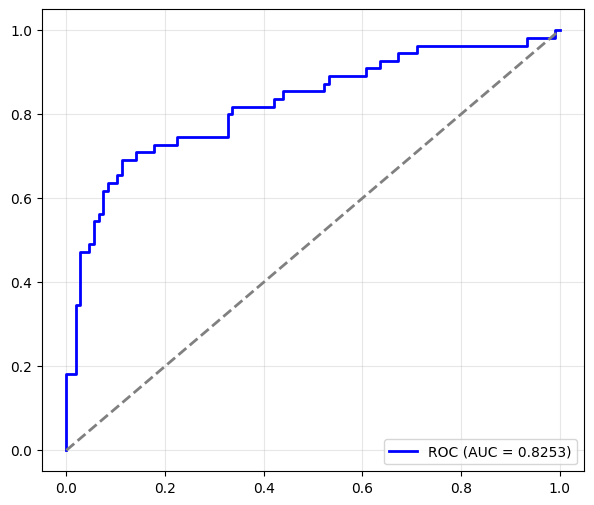

In [ ]:
print("\n--- Evaluating Simple Ensemble Model on the Test Set ---")

print("\n--- Combining Predictions and Tuning the Threshold ---")

cnn_weight = 0.5
xgb_weight = 0.5

# Combining predictions for the test set
y_pred_probs_ensemble = (cnn_weight * test_preds_cnn) + (xgb_weight * test_preds_xgb)

# Applying the OPTIMAL THRESHOLD to the combined test probabilities
y_pred_ensemble_tuned = (y_pred_probs_ensemble >= 0.55).astype(int)

# --- Calculating and Displaying All Metrics ---
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble_tuned)
auc_ensemble = roc_auc_score(y_test, y_pred_probs_ensemble)
kappa_ensemble = cohen_kappa_score(y_test, y_pred_ensemble_tuned)
mcc_ensemble = matthews_corrcoef(y_test, y_pred_ensemble_tuned)

print(f"\nOverall Performance Metrics (Test Set with Tuned Threshold):")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"AUC Score: {auc_ensemble:.4f}")
print(f"Cohen's Kappa: {kappa_ensemble:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_ensemble:.4f}")

print("\nClassification Report (Tuned Threshold):")
print(classification_report(y_test, y_pred_ensemble_tuned, target_names=["Susceptible (0)", "Resistant (1)"], digits=4))

print("\nConfusion Matrix (Tuned Threshold):")
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble_tuned)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues')
#plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (Simple Ensemble)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- ROC Curve ---
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_pred_probs_ensemble)
plt.figure(figsize=(7, 6))
plt.plot(fpr_ens, tpr_ens, color='blue', lw=2, label=f'ROC (AUC = {auc_ensemble:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
#plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (Simple Ensemble)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# **GEN**

#**Setup & Imports**

In [ ]:
print("Setup Complete for Simple Prediction Averaging Ensemble.")

# --- Configuration ---
SNP_MATRIX_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_multi_data.csv"
PHENOTYPES_FILE = "/content/drive/MyDrive/AMR/Giessen_dataset/cip_ctx_ctz_gen_pheno.csv"
TARGET_ANTIBIOTIC = "GEN"

# Saved Model Paths
CNN_MODEL_PATH = "/content/drive/MyDrive/AMR/Trained Weights/best_cnn1d_model_GEN.keras"
XGB_MODEL_PATH = "/content/drive/MyDrive/AMR/Trained Weights/best_xgboost_model_GEN.json"

# Data Splitting Ratio
TEST_SPLIT = 0.2

# Seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Setup Complete for Simple Prediction Averaging Ensemble.


# **Initial Preprocessing**

In [ ]:
print("\n--- Loading Data and Performing Identical Split ---")
snp_df_raw = pd.read_csv(SNP_MATRIX_FILE)
pheno_df = pd.read_csv(PHENOTYPES_FILE)
snp_df = snp_df_raw.set_index('prename')
pheno_df = pheno_df.set_index('prename')
merged_df = snp_df.join(pheno_df[TARGET_ANTIBIOTIC], how='inner')
merged_df = merged_df.dropna(subset=[TARGET_ANTIBIOTIC])
merged_df = merged_df.fillna(0)

labels = merged_df[TARGET_ANTIBIOTIC].values.astype(np.int32)
X = merged_df.drop(columns=[TARGET_ANTIBIOTIC]).values.astype(np.int32)

X_train, X_test, y_train, y_test = train_test_split(
    X, labels,
    test_size=TEST_SPLIT,
    random_state=42,
    stratify=labels
)

print(f"Loaded {len(y_train)} training samples and {len(y_test)} test samples.")


--- Loading Data and Performing Identical Split ---
Loaded 647 training samples and 162 test samples.


# **Loading Model & Predictions**

In [ ]:
print("\n--- Loading Pre-Trained Models and Generating Predictions ---")

# --- Loading Models ---
try:
    cnn_model = keras.models.load_model(CNN_MODEL_PATH)
    xgb_model = xgb.XGBClassifier()
    xgb_model.load_model(XGB_MODEL_PATH)
    print("Base models loaded successfully.")
except Exception as e:
    print(f"Error loading models: {e}")
    exit()

# We need test set predictions for the final evaluation
print("Generating predictions for the test set (for final evaluation)...")
test_preds_cnn = cnn_model.predict(X_test, verbose=0).ravel()
test_preds_xgb = xgb_model.predict_proba(X_test)[:, 1]


--- Loading Pre-Trained Models and Generating Predictions ---
Base models loaded successfully.
Generating predictions for the test set (for final evaluation)...


# **Model Evaluation**


--- Evaluating Simple Ensemble Model on the Test Set ---

--- Combining Predictions and Tuning the Threshold ---

Overall Performance Metrics (Test Set with Tuned Threshold):
Accuracy: 0.7469
AUC Score: 0.7639
Cohen's Kappa: 0.3899
Matthews Correlation Coefficient (MCC): 0.4030

Classification Report (Tuned Threshold):
                 precision    recall  f1-score   support

Susceptible (0)     0.8879    0.7661    0.8225       124
  Resistant (1)     0.4727    0.6842    0.5591        38

       accuracy                         0.7469       162
      macro avg     0.6803    0.7252    0.6908       162
   weighted avg     0.7905    0.7469    0.7607       162


Confusion Matrix (Tuned Threshold):


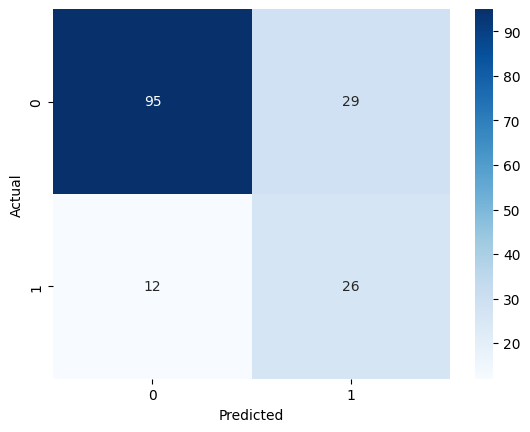

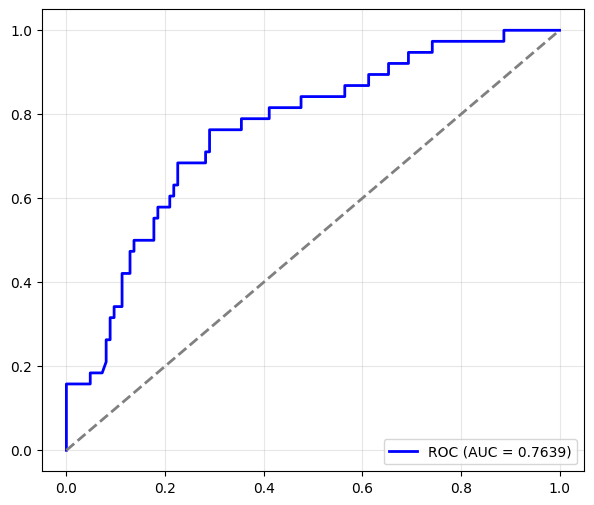

In [ ]:
print("\n--- Evaluating Simple Ensemble Model on the Test Set ---")

print("\n--- Combining Predictions and Tuning the Threshold ---")

cnn_weight = 0.5
xgb_weight = 0.5

# Combining predictions for the test set
y_pred_probs_ensemble = (cnn_weight * test_preds_cnn) + (xgb_weight * test_preds_xgb)

# Applying the OPTIMAL THRESHOLD to the combined test probabilities
y_pred_ensemble_tuned = (y_pred_probs_ensemble >= 0.48).astype(int)

# --- Calculating and Displaying All Metrics ---
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble_tuned)
auc_ensemble = roc_auc_score(y_test, y_pred_probs_ensemble)
kappa_ensemble = cohen_kappa_score(y_test, y_pred_ensemble_tuned)
mcc_ensemble = matthews_corrcoef(y_test, y_pred_ensemble_tuned)

print(f"\nOverall Performance Metrics (Test Set with Tuned Threshold):")
print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"AUC Score: {auc_ensemble:.4f}")
print(f"Cohen's Kappa: {kappa_ensemble:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_ensemble:.4f}")

print("\nClassification Report (Tuned Threshold):")
print(classification_report(y_test, y_pred_ensemble_tuned, target_names=["Susceptible (0)", "Resistant (1)"], digits=4))

print("\nConfusion Matrix (Tuned Threshold):")
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble_tuned)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues')
#plt.title(f'Confusion Matrix - {TARGET_ANTIBIOTIC} (Simple Ensemble)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- ROC Curve ---
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_pred_probs_ensemble)
plt.figure(figsize=(7, 6))
plt.plot(fpr_ens, tpr_ens, color='blue', lw=2, label=f'ROC (AUC = {auc_ensemble:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
#plt.title(f'ROC Curve - {TARGET_ANTIBIOTIC} (Simple Ensemble)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()